In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import FlowCal
import flowsom as fs
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn_extra.cluster import CLARA
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import networkx as nx
import re
from flowio import create_fcs
from scipy.stats import gmean
from fcsy import DataFrame
from fcsy import write_fcs
import matplotlib.colors as mcolors
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score, adjusted_rand_score
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
# Definir los directorios de entrada y salida
work_dir = r"C:/Users/Usuario/OneDrive/Escritorio/Palex/Muestras TFM/SAMPLES_SCAFOLD"
input_dir = work_dir + '/Muestras_cluster'
output_dir = work_dir + '/clusters_clara'
flowsom_dir = work_dir + '/clusters_flowsom'
flowsom_unidos_dir = work_dir + '/clusters_flowsom_unidos'
phenograph_dir = work_dir + '/clusters_phenograph'
clara_dir = work_dir + '/clusters_clara'
clara_unidos_dir = work_dir + '/clusters_clara_unidos'
clara_controles_sep_dir = work_dir + '/clusters_clara_controles_sep'

In [3]:
# Función para limpiar nombres de variables
def limpiar_nombre_variable(nombre):
    # Reemplazar caracteres no deseados con un guion bajo o eliminarlos (en este caso se eliminan)
    nombre_limpio = re.sub(r'[^\w]', '_', nombre)
    return nombre_limpio

Cogemos las muestras y controles normalizados con CyCombine

In [4]:
# Cogemos los labels antes de normalizar para añadirlos al final
gated_dir = work_dir + '/Controles_muestras_gated'
archivos_fcs = [f for f in os.listdir(gated_dir) if f.endswith('.fcs')]

# Lista para almacenar las columnas OmiqFilter
omiq_filter_list = []

# Procesar cada archivo FCS
for archivo in archivos_fcs:
    archivo_fcs = os.path.join(gated_dir, archivo)
    
    # Leer el archivo FCS
    fcs_data = FlowCal.io.FCSData(archivo_fcs)
    
    # Convertir el objeto FCSData a un DataFrame de pandas
    df = pd.DataFrame(fcs_data, columns=fcs_data.channels)
    
    # Almacenar la columna OmiqFilter en la lista
    omiq_filter_list.extend(df['OmiqFilter'].tolist())


Guardamos en un df solo el gating de los controles para hacer los nodos landmark y en otro guardamos todo (controles y muestras)

In [5]:
Norm_dir = work_dir + '/Controles_muestras_normalizados'
archivo_controles = 'Controles_muestras_normalizados.csv'
archivo = os.path.join(Norm_dir, archivo_controles)

df_gating_muestras_controles = pd.read_csv(archivo)

# Añadir la columna OmiqFilter a los datos de gating
df_gating_muestras_controles['OmiqFilter'] = omiq_filter_list

In [6]:
# Cambiamos los valores de la columna OmiqFilter por los nombres reales
omiq_filter_dict = {
    0: "NA",
    1: "CM CD8",
    2: "Monocitos intermedios",
    3: "Treg",
    4: "TEMRA CD8",
    5: "Monocitos clasicos",
    6: "Monocitos no clasicos",
    7: "Non Treg",
    8: "Linfocitos B",
    9: "NK",
    10: "EM CD8",
    11: "Granulocitos",
    12: "Naive CD8"
}
df_gating_muestras_controles['OmiqFilter'] = df_gating_muestras_controles['OmiqFilter'].replace(omiq_filter_dict)

In [7]:
# Asegurarse de que la columna 'sample' es de tipo cadena (string)
df_gating_muestras_controles['sample'] = df_gating_muestras_controles['sample'].astype(str)

# Filtrar las filas donde 'sample' empieza con 'C' y no es nulo
df_gating = df_gating_muestras_controles[
    df_gating_muestras_controles['sample'].str.startswith('C')
]

In [8]:
df_gating = df_gating.drop(columns=['sample', 'batch','condition','id','label'])
# Eliminamos las filas que tienen NA en la columna OmiqFilter (no queremos un nodo NA)
df_gating = df_gating[df_gating['OmiqFilter'] != 'NA']

# No dropeamos sample porque lo usamos despues para comparar distribuciones con los clusters
df_gating_muestras_controles = df_gating_muestras_controles.drop(columns=['batch','condition','id','label'])

Calculamos el MFI de cada marcador (media o mediana) para calcular la similitud de cada par de nodos

In [9]:
# Primero vamos a coger las poblaciones obtenidas por gating
medianas = pd.DataFrame()
medias = pd.DataFrame()

# Agrupar por 'OmiqFilter' y calcular medianas, medias y medias geométricas
grouped = df_gating.groupby('OmiqFilter')

for poblacion, group in grouped:
    # Obtener el nombre de la población desde la columna 'OmiqFilter'
    variable_name = limpiar_nombre_variable(poblacion)
    
    # Excluir la columna 'OmiqFilter'
    df_gating_numeric = group.drop(columns=['OmiqFilter'])
    
    # Guardar el DataFrame en una variable global
    globals()[variable_name] = df_gating_numeric
    
    # Calcular medianas, medias y medias geométricas
    medianas[variable_name] = df_gating_numeric.median()
    medias[variable_name] = df_gating_numeric.mean()

# Transponer los DataFrames de medianas, medias
medias_gating = medias.T
medianas_gating = medianas.T

In [10]:
cosine_similarities = cosine_similarity(medianas_gating)
cosine_similarities = pd.DataFrame(cosine_similarities, index=medianas_gating.index, columns=medianas_gating.index)

## Calculo de la significancia en los cambios de poblaciones según grupo
Guardamos en un dataframe (df_clustering) todas las células que hemos clusterizado asignandoles una población según la similitud del cluster (o unassigned si no llega al umbral establecido)

## Un clustering por muestra

In [17]:
# Definir el directorio donde estan los clusters
dir_clusters = phenograph_dir

In [18]:
# Obtener la lista de archivos de control y muestras
control_files = [f for f in os.listdir(dir_clusters) if f.startswith('C') and f.endswith('.csv')]
archivos = [f for f in os.listdir(dir_clusters) if f.endswith('.csv') and not f.startswith('C')]
# Combinar las listas de controles y muestras para un procesamiento unificado
todos_los_archivos = control_files + archivos

jerarquia= {}

In [19]:
def obtener_poblacion_padre(poblacion, jerarquia):
    """
    Retorna el nombre de la población padre si existe, 
    de lo contrario, retorna la misma población.
    """
    for padre, hijos in jerarquia.items():
        if poblacion in hijos:
            return padre
    return poblacion

### Primera opción: UNA sola poblacion por cluster

In [20]:
umbrales_clusters_gating = 0.95

# Crear el grafo principal
G = nx.Graph()

# Crear una lista de nombres de nodos de gating
nodos_gating = medianas_gating.index.tolist()

# Añadir nodos de gating al grafo
for nodo in nodos_gating:
    num_eventos = len(globals()[limpiar_nombre_variable(nodo)])  # Calcula el número de eventos para los nodos de gating
    size = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
    G.add_node(nodo, color='red', size=size)

# Crear una matriz de similitud del coseno usando medianas_gating
valores_medianos_gating = medianas_gating.values
matriz_similitud_coseno_gating = cosine_similarity(valores_medianos_gating)
np.fill_diagonal(matriz_similitud_coseno_gating, 0)
umbrales_gating = np.percentile(matriz_similitud_coseno_gating, 60, axis=0)

# Añadir aristas solo entre nodos similares basados en el umbral de similitud del coseno
for i in range(len(nodos_gating)):
    for j in range(i + 1, len(nodos_gating)):
        if matriz_similitud_coseno_gating[i, j] >= umbrales_gating[j]:
            G.add_edge(nodos_gating[i], nodos_gating[j], weight=matriz_similitud_coseno_gating[i, j]**4, color='red')

# Calcular las posiciones de los nodos de gating
pos_gating = nx.spring_layout(G, weight='weight', seed=2)

# Inicializar df_clustering vacío
df_clustering = pd.DataFrame()

# Preparar colores para los archivos
num_archivos = len(todos_los_archivos)
colores = sns.color_palette('husl', num_archivos)

leyenda = {}
tamanos_nodos = {}
nodos_cluster_todos = []

clusters_unidos_a_gating = {nodo_gating: [] for nodo_gating in nodos_gating}

# Procesar cada archivo
for idx, archivo in enumerate(todos_los_archivos):
    archivo_path = os.path.join(dir_clusters, archivo)
    df_cluster = pd.read_csv(archivo_path)

    # Eliminar columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_cluster = df_cluster.drop(columns=[col for col in columnas_a_eliminar if col in df_cluster.columns])

    # Calcular las medianas del cluster
    medianas_cluster = df_cluster.groupby('cluster').median()
    nombre_muestra = archivo.split('_clusters.csv')[0]
    medianas_cluster = medianas_cluster.rename(index=lambda x: f"C_{x}_{nombre_muestra.split('-')[0]}")
    medianas_todo = pd.concat([medianas_gating, medianas_cluster], axis=0)

    nodos_clusters = medianas_cluster.index.tolist()
    nodos_cluster_todos.extend(nodos_clusters)

    # Crear una matriz de similitud del coseno
    indices_similitud = nodos_clusters + nodos_gating
    valores_medianos = medianas_todo.loc[indices_similitud].values
    matriz_similitud_coseno = cosine_similarity(valores_medianos)
    df_similitud_coseno = pd.DataFrame(matriz_similitud_coseno, index=indices_similitud, columns=indices_similitud)


    # Añadir nodos de clusters al grafo
    for nodo in nodos_clusters:
        cluster_num = int(nodo.split('_')[1])
        num_eventos = len(df_cluster[df_cluster['cluster'] == cluster_num])
        tamanos_nodos[nodo] = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
        G.add_node(nodo, color=colores[idx], size=tamanos_nodos[nodo])

    # Añadir entrada a la leyenda
    leyenda[nombre_muestra.split('-')[0]] = colores[idx]

    # Añadir aristas entre clusters y nodos de gating
    for nodo_cluster in nodos_clusters:
        for nodo_gating in nodos_gating:
            if nodo_cluster in df_similitud_coseno.index and nodo_gating in df_similitud_coseno.columns:
                similitud = df_similitud_coseno.at[nodo_cluster, nodo_gating]
                if similitud >= umbrales_clusters_gating:
                    G.add_edge(nodo_cluster, nodo_gating, weight=similitud**4, color=colores[idx])
                    clusters_unidos_a_gating[nodo_gating].append(nodo_cluster)

    # Calcular posiciones de los nodos
    pos = nx.spring_layout(G, pos=pos_gating, fixed=nodos_gating, weight='weight',
                           k=0.02 / np.mean(matriz_similitud_coseno), seed=1)

    # Crear df_clustering y asignar la población
    df_cluster_mod = df_cluster.copy()

    # Obtener la similitud entre clusters y poblaciones de gating
    clusters_indices = nodos_clusters
    gating_indices = nodos_gating

    df_similitudes = df_similitud_coseno.loc[clusters_indices, gating_indices]

    # Encontrar la similitud máxima por cluster y su población correspondiente
    max_similitudes = df_similitudes.max(axis=1)
    asignaciones_clusters = df_similitudes.idxmax(axis=1)

    # Crear un diccionario de asignación cluster -> población
    dict_asignaciones = {}
    for cluster in clusters_indices:
        cluster_num = int(cluster.split('_')[1])
        if max_similitudes[cluster] >= umbrales_clusters_gating:
            dict_asignaciones[cluster_num] = asignaciones_clusters[cluster]
        else:
            dict_asignaciones[cluster_num] = 'Unassigned'

    # Añadir la columna 'Poblacion' al DataFrame
    df_cluster_mod['Poblacion'] = df_cluster_mod['cluster'].map(dict_asignaciones)

    # Añadir una columna para identificar la muestra
    df_cluster_mod['Muestra'] = nombre_muestra.split('-')[0]

    # Concatenar al DataFrame global
    df_clustering = pd.concat([df_clustering, df_cluster_mod], ignore_index=True)

# Recalcular posiciones del grafo principal si es necesario
pos_gating_general = pos

In [77]:
jerarquia = {'CD4': ['Treg', 'Non_Treg'], 
             'CD8': ['EM_CD8', 'TEMRA_CD8', 'CM_CD8', 'Naive_CD8'],
             'NK': ['NK'],
             'Granulocitos': ['Granulocitos'],
             'Monocitos': ['Monocitos_no_clasicos', 'Monocitos_intermedios', 'Monocitos_clasicos'],
             'Linfocitos_B': ['Linfocitos_B']
             }

C:\Users\Usuario\AppData\Local\Temp\ipykernel_30580\2556402706.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['PoblacionPadre'] = filtered_df['Poblacion'].apply(


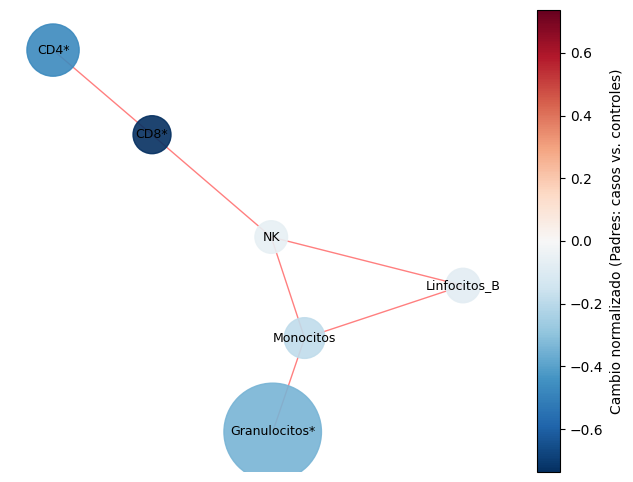

In [80]:
df_clustering['Group'] = df_clustering['Muestra'].apply(
    lambda x: 'Control' if x.startswith('C') else ('Case' if x.startswith('PRETR') else 'Unknown')
)

###############################################################################
# 2) Agrupar por muestra, grupo y población hija (conteo de células)
###############################################################################
counts_per_sample = df_clustering.groupby(['Muestra', 'Group', 'Poblacion']).size().reset_index(name='Count')

counts_pivot = counts_per_sample.pivot_table(
    index=['Muestra', 'Group'],
    columns='Poblacion',
    values='Count',
    fill_value=0
)

###############################################################################
# 3) Calcular significancia (poblaciones hijas)
###############################################################################
results_hijos = []
for poblacion in counts_pivot.columns:
    sub_data = counts_pivot[poblacion].reset_index()
    control_counts = sub_data[sub_data['Group'] == 'Control'][poblacion]
    case_counts    = sub_data[sub_data['Group'] == 'Case'][poblacion]

    control_mean = control_counts.mean()
    case_mean    = case_counts.mean()

    if control_mean != 0:
        change = (case_mean - control_mean) / control_mean
    else:
        change = np.nan

    if not control_counts.empty and not case_counts.empty:
        _, pvalue = mannwhitneyu(control_counts, case_counts, alternative='two-sided')
    else:
        pvalue = np.nan

    results_hijos.append({
        'Poblacion': poblacion,
        'Change': change,
        'pvalue': pvalue
    })

results_df_hijos = pd.DataFrame(results_hijos)
results_df_hijos['p_adj'] = multipletests(results_df_hijos['pvalue'], method='fdr_bh')[1]

###############################################################################
# 4) Filtrar dataFrame y crear mapeo hijo->padre (desde la jerarquía)
###############################################################################
filtered_df = df_clustering[~df_clustering['Poblacion'].isin(['Unassigned'])]

child_to_father = {}
for padre, hijos in jerarquia.items():
    for hijo in hijos:
        child_to_father[hijo] = padre

# Crear nueva columna con el padre de cada hijo (si no existe, se queda igual)
filtered_df['PoblacionPadre'] = filtered_df['Poblacion'].apply(
    lambda h: child_to_father[h] if h in child_to_father else h
)

###############################################################################
# 5) Agrupar por Muestra, Group y PoblacionPadre (suma de células del padre)
###############################################################################
counts_per_parent = filtered_df.groupby(['Muestra', 'Group', 'PoblacionPadre']).size().reset_index(name='Count')

counts_pivot_padre = counts_per_parent.pivot_table(
    index=['Muestra', 'Group'],
    columns='PoblacionPadre',
    values='Count',
    fill_value=0
)

###############################################################################
# 6) Calcular significancia para poblaciones padre
###############################################################################
results_padre = []
for padre in counts_pivot_padre.columns:
    sub_data = counts_pivot_padre[padre].reset_index()
    control_counts = sub_data[sub_data['Group'] == 'Control'][padre]
    case_counts    = sub_data[sub_data['Group'] == 'Case'][padre]

    control_mean = control_counts.mean()
    case_mean    = case_counts.mean()

    if control_mean != 0:
        change = (case_mean - control_mean) / control_mean
    else:
        change = np.nan

    if not control_counts.empty and not case_counts.empty:
        _, pvalue = mannwhitneyu(control_counts, case_counts, alternative='two-sided')
    else:
        pvalue = np.nan

    results_padre.append({
        'Padre': padre,
        'Change': change,
        'pvalue': pvalue
    })

results_df_padre = pd.DataFrame(results_padre)
results_df_padre['p_adj'] = multipletests(results_df_padre['pvalue'], method='fdr_bh')[1]

###############################################################################
# 7) Preparar normalización de color para padres
###############################################################################
filtered_padres = results_df_padre[~results_df_padre['Padre'].isin(['Unassigned'])]
max_change_p    = filtered_padres['Change'].abs().max() if not filtered_padres.empty else 0
norm_padres     = plt.Normalize(vmin=-max_change_p, vmax=max_change_p)
cmap_padres     = plt.cm.RdBu_r

# Crear mapa de color y etiquetas para los padres según su cambio
father_color_map = {}
father_label_map = {}
for _, row in results_df_padre.iterrows():
    padre  = row['Padre']
    change = row['Change']
    p_adj  = row['p_adj']

    if not np.isnan(change):
        color_hex = mcolors.to_hex(cmap_padres(norm_padres(change)))
    else:
        color_hex = '#cccccc'

    label = padre
    if p_adj < 0.05:
        label += '*'

    father_color_map[padre] = color_hex
    father_label_map[padre] = label

###############################################################################
# 8) Construir el grafo original de hijos (G_original) para ver conexiones
###############################################################################
G_original = nx.Graph()

# Lista de hijos únicos (excluyendo 'Unassigned')
hijos_unicos = filtered_df['Poblacion'].unique()

# Añadir nodos hijos
for hijo in hijos_unicos:
    G_original.add_node(hijo)

# Calcular matriz de similitud y umbrales (65%) para hijos
valores_hijos = medianas_gating.loc[hijos_unicos].values
matriz_similitud = cosine_similarity(valores_hijos)
np.fill_diagonal(matriz_similitud, 0)
umbrales = np.percentile(matriz_similitud, 65, axis=0)

# Añadir aristas en G_original
for i in range(len(hijos_unicos)):
    for j in range(i + 1, len(hijos_unicos)):
        if matriz_similitud[i, j] >= umbrales[j]:
            G_original.add_edge(
                hijos_unicos[i],
                hijos_unicos[j],
                weight=matriz_similitud[i, j]**4,
                color='red'
            )

###############################################################################
# 9) Construir el grafo de padres (G_padres) y asignar tamaño
###############################################################################
G_padres = nx.Graph()

# NUEVO: calcular la suma total de células para cada padre
# (independientemente de Control/Caso, es el total de sus hijos en 'filtered_df')
father_sums = counts_per_parent.groupby('PoblacionPadre')['Count'].sum().to_dict()

# Añadir nodos padre con color, etiqueta y tamaño basado en la suma de sus hijos
for padre in jerarquia.keys():
    total_celulas = father_sums.get(padre, 0)
    # Ajustar factor de escala según convenga
    scaled_size = total_celulas * 0.005

    G_padres.add_node(
        padre,
        color=father_color_map.get(padre, '#cccccc'),
        label=father_label_map.get(padre, padre),
        size=scaled_size
    )

# Conectar padres si sus hijos están conectados en G_original
for (childA, childB) in G_original.edges():
    padreA = child_to_father.get(childA)
    padreB = child_to_father.get(childB)
    if padreA and padreB and padreA != padreB:
        if padreA in G_padres and padreB in G_padres:
            G_padres.add_edge(padreA, padreB, color='red')

###############################################################################
# 10) Dibujar el grafo de padres con su tamaño, color y etiqueta
###############################################################################
pos = nx.spring_layout(G_padres, seed=1)
fig, ax = plt.subplots(figsize=(8, 6))

nx.draw_networkx_nodes(
    G_padres, pos,
    node_color=[G_padres.nodes[n]['color'] for n in G_padres.nodes()],
    node_size=[G_padres.nodes[n]['size'] for n in G_padres.nodes()],
    alpha=0.9, ax=ax
)

nx.draw_networkx_edges(
    G_padres, pos,
    edge_color=[G_padres[u][v]['color'] for u, v in G_padres.edges()],
    alpha=0.5, ax=ax
)

labels = {n: G_padres.nodes[n].get('label', n) for n in G_padres.nodes()}
nx.draw_networkx_labels(G_padres, pos, labels=labels, font_size=9, ax=ax)

# Barra de color para padres
sm = plt.cm.ScalarMappable(cmap=cmap_padres, norm=norm_padres)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Cambio normalizado (Padres: casos vs. controles)")

ax.axis('off')
plt.show()

Sin jerarquias

In [21]:
jerarquia = {}

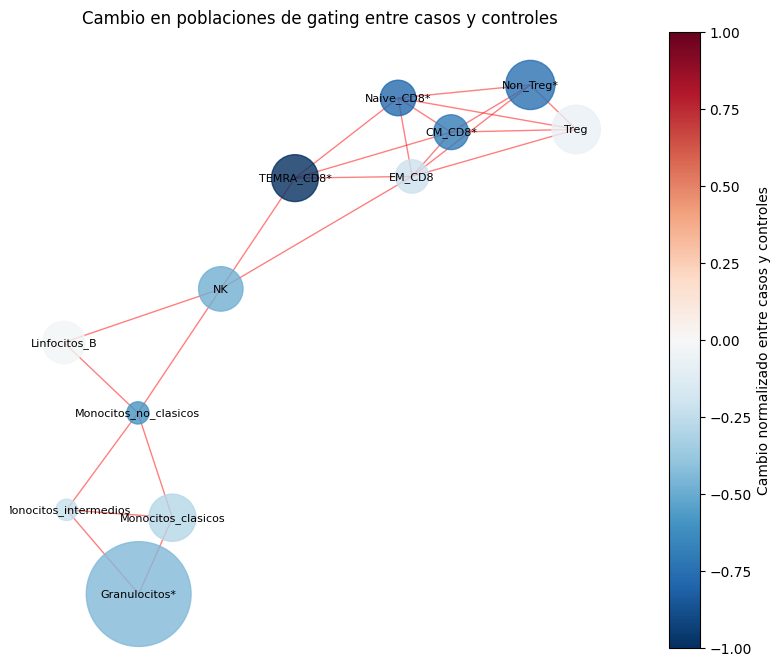

In [22]:
# 1) Asignar grupos a partir del nombre de la muestra
df_clustering['Group'] = df_clustering['Muestra'].apply(
    lambda x: 'Control' if x.startswith('C') else ('Case' if x.startswith('PRETR') else 'Unknown')
)

# 2) Calcular el número de células por muestra y población de gating
counts_per_sample = df_clustering.groupby(['Muestra', 'Group', 'Poblacion']).size().reset_index(name='Count')

# 3) Crear tabla pivote: filas -> (Muestra, Group), columnas -> Poblacion, valores -> Count
counts_pivot = counts_per_sample.pivot_table(
    index=['Muestra', 'Group'], 
    columns='Poblacion', 
    values='Count', 
    fill_value=0
)

# 4) Calcular cambios y significancia entre Control y Caso para cada población
results = []
for poblacion in counts_pivot.columns:
    data = counts_pivot[poblacion].reset_index()
    control_counts = data[data['Group'] == 'Control'][poblacion]
    case_counts = data[data['Group'] == 'Case'][poblacion]

    control_mean = control_counts.mean()
    case_mean = case_counts.mean()

    if control_mean != 0:
        change = (case_mean - control_mean) / control_mean
    else:
        change = np.nan

    if not control_counts.empty and not case_counts.empty:
        stat, pvalue = mannwhitneyu(control_counts, case_counts, alternative='two-sided')
    else:
        pvalue = np.nan

    results.append({
        'Poblacion': poblacion,
        'Control_Mean': control_mean,
        'Case_Mean': case_mean,
        'Change': change,
        'pvalue': pvalue
    })

results_df = pd.DataFrame(results)

# 5) Ajuste de p-valores FDR
results_df['p_adj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

# 6) Calcular el rango de cambio para la escala de color
filtered_df = results_df[results_df['Poblacion'] != 'Unassigned']
max_change = filtered_df['Change'].abs().max() if not filtered_df.empty else 0

norm = plt.Normalize(vmin=-max_change, vmax=max_change)
cmap = plt.cm.RdBu_r

# 7) Diccionarios para color y label de cada población
color_map = {}
label_map = {}
for idx, row in results_df.iterrows():
    poblacion = row['Poblacion']
    cambio = row['Change']
    p_adj = row['p_adj']
    if not np.isnan(cambio):
        color = cmap(norm(cambio))
        color_hex = mcolors.to_hex(color)
    else:
        color_hex = '#cccccc'
    color_map[poblacion] = color_hex

    label_txt = poblacion
    if p_adj < 0.05:
        label_txt += '*'
    label_map[poblacion] = label_txt

# 8) NUEVO: Calcular el tamaño del nodo según el promedio de células por población
#    (en todas las muestras o en su defecto 0)
avg_cells_per_pop = counts_per_sample.groupby('Poblacion')['Count'].mean().to_dict()

# 9) Construir el grafo
G = nx.Graph()

# 9.1 Añadir nodos padre
for grupo in jerarquia.keys():
    G.add_node(grupo, tipo='padre', color='darkred', size=300)

# 9.2 Añadir nodos gating con tamaño según su promedio de células
for nodo in nodos_gating:
    if nodo not in jerarquia:
        # Escalar el tamaño para que no sea demasiado grande
        base_size = avg_cells_per_pop.get(nodo, 1.0)
        scaled_size = base_size * 0.15  # Ajusta este factor según convenga
        G.add_node(
            nodo,
            tipo='gating',
            color=color_map.get(nodo, 'red'),
            size=scaled_size,
            label=label_map.get(nodo, nodo)
        )

# 9.3 Añadir aristas entre nodos gating basadas en similitud
valores_medianos_gating = medianas_gating.values
matriz_similitud_coseno_gating = cosine_similarity(valores_medianos_gating)
np.fill_diagonal(matriz_similitud_coseno_gating, 0)
umbrales_gating = np.percentile(matriz_similitud_coseno_gating, 65, axis=0)

for i in range(len(nodos_gating)):
    for j in range(i + 1, len(nodos_gating)):
        if matriz_similitud_coseno_gating[i, j] >= umbrales_gating[j]:
            G.add_edge(nodos_gating[i], nodos_gating[j], weight=matriz_similitud_coseno_gating[i, j]**4, color='red')

# 9.4 Conectar nodos hijos con sus padres
for grupo, subnodos in jerarquia.items():
    for subnodo in subnodos:
        if subnodo in G:
            G.add_edge(grupo, subnodo, weight=1, color='grey')

# 10) Calcular posiciones y dibujar
pos = nx.spring_layout(G, weight='weight', seed=1)
fig, ax = plt.subplots(figsize=(10, 8))

nodos_gating_padre = [nodo for nodo in G.nodes() if G.nodes[nodo]['tipo'] in ['gating', 'padre']]
nx.draw_networkx_nodes(
    G, pos,
    nodelist=nodos_gating_padre,
    node_color=[G.nodes[n]['color'] for n in nodos_gating_padre],
    node_size=[G.nodes[n]['size'] for n in nodos_gating_padre],
    alpha=0.8, ax=ax
)
nx.draw_networkx_edges(
    G, pos,
    edge_color=[G[u][v]['color'] for u, v in G.edges()],
    alpha=0.5, ax=ax
)

labels = {nodo: G.nodes[nodo].get('label', nodo) for nodo in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', ax=ax)

# Barra de colores según cambio normalizado
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cambio normalizado entre casos y controles')

ax.set_title("Cambio en poblaciones de gating entre casos y controles")
ax.axis('off')
plt.show()

In [50]:
df = df_gating_muestras_controles.copy()

# 1. Calcular cuántas veces aparece cada población (OmiqFilter) en cada muestra (sample)
counts = df.groupby(['sample', 'OmiqFilter']).size().reset_index(name='frecuencia')

resultados = []
# 2. Iterar por cada población (cada valor de OmiqFilter en "counts")
for poblacion, subdf in counts.groupby('OmiqFilter'):
    # Dividir en subgrupos: controles (empiezan por 'C') y casos (empiezan por 'PRETR')
    subdf_controles = subdf[subdf['sample'].str.startswith('C')]
    subdf_casos = subdf[subdf['sample'].str.startswith('PRETR')]

    # Medias de frecuencias
    media_controles = subdf_controles['frecuencia'].mean() if not subdf_controles.empty else np.nan
    media_casos = subdf_casos['frecuencia'].mean() if not subdf_casos.empty else np.nan

    # Cambio normalizado
    if media_controles != 0:
        cambio = (media_casos - media_controles) / media_controles
    else:
        cambio = np.nan

    # p-valor con Mann-Whitney U si ambos grupos tienen datos
    if not subdf_controles.empty and not subdf_casos.empty:
        _, pvalor = mannwhitneyu(subdf_controles['frecuencia'], subdf_casos['frecuencia'], alternative='two-sided')
    else:
        pvalor = np.nan

    resultados.append({
        'OmiqFilter': poblacion,
        'Media_Control': media_controles,
        'Media_Caso': media_casos,
        'Cambio': cambio,
        'pvalor': pvalor
    })

# 3. Construir DataFrame y ajustar p-valores FDR
resultados_df = pd.DataFrame(resultados)
resultados_df['pvalor_ajustado'] = multipletests(resultados_df['pvalor'], method='fdr_bh')[1]

# Mostrar los resultados
resultados_df

,OmiqFilter,Media_Control,Media_Caso,Cambio,pvalor,pvalor_ajustado
0,CM CD8,267.8,375.666667,0.402788,0.212003,0.378664
1,EM CD8,2929.2,2102.200000,-0.282330,0.127153,0.330598
2,Granulocitos,52769.6,44234.400000,-0.161745,0.359965,0.456316
3,Linfocitos B,4423.1,6672.400000,0.508535,0.101763,0.330598
4,Monocitos clasicos,7197.9,6364.866667,-0.115733,0.360058,0.456316
5,Monocitos intermedios,442.5,571.200000,0.290847,0.977874,0.977874
6,Monocitos no clasicos,130.3,429.733333,2.298030,0.080526,0.330598
7,NA,20257.0,9678.866667,-0.522196,0.000791,0.010283
8,NK,2297.2,5645.000000,1.457339,0.028417,0.184708
9,Naive CD8,5534.5,8057.400000,0.455850,0.389907,0.456316


### Segunda opción: TODAS las poblaciones que superen el umbral

In [94]:
umbrales_clusters_gating = 0.9
# Crear el grafo principal
G = nx.Graph()

# Crear una lista de nombres de nodos de gating
nodos_gating = medianas_gating.index.tolist()

# Añadir nodos de gating al grafo
for nodo in nodos_gating:
    num_eventos = len(globals()[limpiar_nombre_variable(nodo)])  # Calcula el número de eventos para los nodos de gating
    size = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
    G.add_node(nodo, color='red', size=size)

# Crear una matriz de similitud del coseno usando medianas_gating
valores_medianos_gating = medianas_gating.values
matriz_similitud_coseno_gating = cosine_similarity(valores_medianos_gating)
np.fill_diagonal(matriz_similitud_coseno_gating, 0)
umbrales_gating = np.percentile(matriz_similitud_coseno_gating, 60, axis=0)

# Añadir aristas solo entre nodos similares basados en el umbral de similitud del coseno
for i in range(len(nodos_gating)):
    for j in range(i + 1, len(nodos_gating)):
        if matriz_similitud_coseno_gating[i, j] >= umbrales_gating[j]:
            G.add_edge(nodos_gating[i], nodos_gating[j], weight=matriz_similitud_coseno_gating[i, j]**4, color='red')

# Calcular las posiciones de los nodos de gating
pos_gating = nx.spring_layout(G, weight='weight', seed=2)

# Inicializar df_clustering vacío
df_clustering = pd.DataFrame()

# Preparar colores para los archivos
num_archivos = len(todos_los_archivos)
colores = sns.color_palette('husl', num_archivos)

leyenda = {}
tamanos_nodos = {}
nodos_cluster_todos = []

clusters_unidos_a_gating = {nodo_gating: [] for nodo_gating in nodos_gating}

# Procesar cada archivo
for idx, archivo in enumerate(todos_los_archivos):
    archivo_path = os.path.join(dir_clusters, archivo)
    df_cluster = pd.read_csv(archivo_path)

    # Eliminar columnas no necesarias
    columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
    df_cluster = df_cluster.drop(columns=[col for col in columnas_a_eliminar if col in df_cluster.columns])

    # Calcular las medianas del cluster
    medianas_cluster = df_cluster.groupby('cluster').median()
    nombre_muestra = archivo.split('_clusters.csv')[0]
    medianas_cluster = medianas_cluster.rename(index=lambda x: f"C_{x}_{nombre_muestra.split('-')[0]}")
    medianas_todo = pd.concat([medianas_gating, medianas_cluster], axis=0)

    nodos_clusters = medianas_cluster.index.tolist()
    nodos_cluster_todos.extend(nodos_clusters)

    # Crear una matriz de similitud del coseno
    indices_similitud = nodos_clusters + nodos_gating
    valores_medianos = medianas_todo.loc[indices_similitud].values
    matriz_similitud_coseno = cosine_similarity(valores_medianos)
    df_similitud_coseno = pd.DataFrame(matriz_similitud_coseno, index=indices_similitud, columns=indices_similitud)


    # Añadir nodos de clusters al grafo
    for nodo in nodos_clusters:
        cluster_num = int(nodo.split('_')[1])
        num_eventos = len(df_cluster[df_cluster['cluster'] == cluster_num])
        tamanos_nodos[nodo] = num_eventos * 0.01  # Ajustar el factor de escala según sea necesario
        G.add_node(nodo, color=colores[idx], size=tamanos_nodos[nodo])

    # Añadir entrada a la leyenda
    leyenda[nombre_muestra.split('-')[0]] = colores[idx]

    

    # Añadir aristas entre clusters y nodos de gating
    for nodo_cluster in nodos_clusters:
        for nodo_gating in nodos_gating:
            if nodo_cluster in df_similitud_coseno.index and nodo_gating in df_similitud_coseno.columns:
                similitud = df_similitud_coseno.at[nodo_cluster, nodo_gating]
                if similitud >= umbrales_clusters_gating:
                    G.add_edge(nodo_cluster, nodo_gating, weight=similitud**4, color=colores[idx])
                    clusters_unidos_a_gating[nodo_gating].append(nodo_cluster)

    # Calcular posiciones de los nodos
    pos = nx.spring_layout(G, pos=pos_gating, fixed=nodos_gating, weight='weight',
                        k=0.02 / np.mean(matriz_similitud_coseno), seed=1)

    # Crear df_clustering y asignar las poblaciones
    df_cluster_mod = df_cluster.copy()

    # Obtener la similitud entre clusters y poblaciones de gating
    clusters_indices = nodos_clusters
    gating_indices = nodos_gating

    df_similitudes = df_similitud_coseno.loc[clusters_indices, gating_indices]

    # Inicializar un diccionario para asignaciones de clusters a poblaciones (listas de poblaciones)
    dict_asignaciones = {}

    for cluster in clusters_indices:
        cluster_num = int(cluster.split('_')[1])

        # Obtener las poblaciones cuya similitud excede el umbral
        poblaciones_asignadas = df_similitudes.columns[df_similitudes.loc[cluster] >= umbrales_clusters_gating].tolist()

        if poblaciones_asignadas:
            dict_asignaciones[cluster_num] = poblaciones_asignadas
        else:
            dict_asignaciones[cluster_num] = ['Unassigned']

    # Añadir la columna 'Poblacion' al DataFrame
    df_cluster_mod['Poblacion'] = df_cluster_mod['cluster'].map(dict_asignaciones)

    # Expandir las filas para que cada célula tenga una fila por población asignada
    df_cluster_exploded = df_cluster_mod.explode('Poblacion').reset_index(drop=True)

    # Añadir una columna para identificar la muestra
    df_cluster_exploded['Muestra'] = nombre_muestra.split('-')[0]

    # Concatenar al DataFrame global
    df_clustering = pd.concat([df_clustering, df_cluster_exploded], ignore_index=True)

### Un solo clustering para todas las muestras

In [97]:
def asignar_poblacion(cluster_id, df_similitud_coseno, nodos_gating, umbral):
    # Obtener las similitudes entre el cluster y los nodos de gating
    similitudes = df_similitud_coseno.loc[cluster_id, nodos_gating]
    max_similitud = similitudes.max()
    if max_similitud >= umbral:
        # Asignar el cluster a la población de gating con la mayor similitud
        poblacion_asignada = similitudes.idxmax()
        return poblacion_asignada
    else:
        # Si la similitud máxima no supera el umbral, asignar como 'Unassigned'
        return 'Unassigned'
    
dir_clusters = clara_unidos_dir

archivos = [f for f in os.listdir(dir_clusters) if f.endswith('_clusters.csv')]

jerarquia = {}

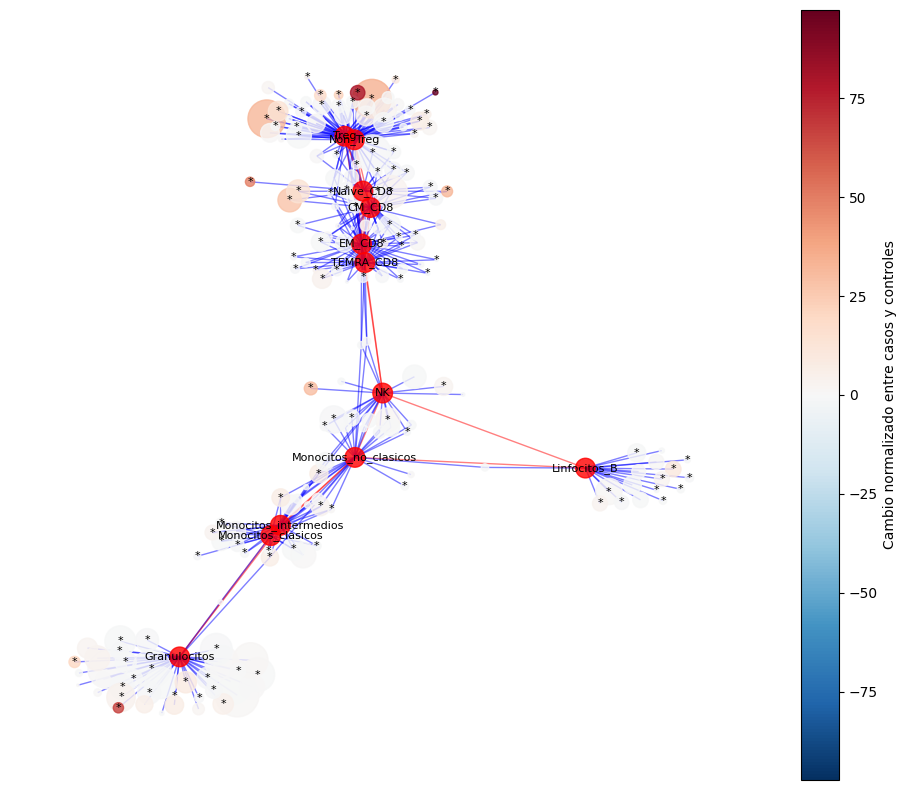

In [103]:
umbral_clusters_gating = 0.9

# 1. Crear el grafo y añadir nodos de Gating¡
G = nx.Graph()

# Crear una lista de nombres de nodos de gating
nodos_gating = medianas_gating.index.tolist()

# Añadir nodos de jerarquía (solo nodos padre)
for grupo in jerarquia.keys():
    G.add_node(grupo, tipo='padre', color='darkred', size=200)

# Añadir nodos de gating (excluyendo nodos padre)
for nodo in nodos_gating:
    if nodo not in jerarquia:
        G.add_node(nodo, tipo='gating', color='red', size=200)

# Crear la matriz de similitud del coseno usando medianas_gating
valores_medianos_gating = medianas_gating.values
matriz_similitud_coseno_gating = cosine_similarity(valores_medianos_gating)
np.fill_diagonal(matriz_similitud_coseno_gating, 0)
umbrales_gating = np.percentile(matriz_similitud_coseno_gating, 65, axis=0)

# Añadir aristas entre nodos de gating basados en la similitud
for i in range(len(nodos_gating)):
    for j in range(i + 1, len(nodos_gating)):
        if matriz_similitud_coseno_gating[i, j] >= umbrales_gating[j]:
            G.add_edge(nodos_gating[i], nodos_gating[j], weight=matriz_similitud_coseno_gating[i, j]**4, color='red')

# Calcular posiciones solo para nodos gating y padres
pos_gating = nx.spring_layout(G, weight='weight', seed=1, k = 0.00001)

# Agrupar nodos hijos bajo nodos padres
for grupo, subnodos in jerarquia.items():
    for subnodo in subnodos:
        if subnodo in G:
            G.add_edge(grupo, subnodo, weight=1, color='red')

#############################################
# 2. Cargar y procesar clusters
#############################################
df_clusters_total = pd.DataFrame()
for archivo in archivos:
    archivo_path = os.path.join(dir_clusters, archivo)
    df_temp = pd.read_csv(archivo_path)
    nombre_muestra = archivo.split('_clusters.csv')[0]
    df_temp['Muestra'] = nombre_muestra
    df_clusters_total = pd.concat([df_clusters_total, df_temp], ignore_index=True)

columnas_a_eliminar = ['condition', 'batch', 'sample', 'id', 'label']
df_clusters_total = df_clusters_total.drop(columns=[col for col in columnas_a_eliminar if col in df_clusters_total.columns])

if 'cluster' not in df_clusters_total.columns:
    raise ValueError("La columna 'cluster' no se encuentra en los datos.")

columnas_numericas = df_clusters_total.select_dtypes(include=[np.number]).columns.tolist()
if 'cluster' in columnas_numericas:
    columnas_numericas.remove('cluster')

medianas_clusters_globales = df_clusters_total.groupby('cluster')[columnas_numericas].median()
medianas_clusters_globales = medianas_clusters_globales.rename(index=lambda x: f"C_{int(x)}")

tamanos_clusters = df_clusters_total['cluster'].value_counts()
tamanos_clusters = tamanos_clusters.rename(index=lambda x: f"C_{int(x)}")

nodos_clusters_conectados = []
medianas_totales = pd.concat([medianas_gating, medianas_clusters_globales], axis=0)
nodos_total = nodos_gating + list(medianas_clusters_globales.index)
valores_medianos = medianas_totales.loc[nodos_total].values
matriz_similitud_coseno = cosine_similarity(valores_medianos)
df_similitud_coseno = pd.DataFrame(matriz_similitud_coseno, index=nodos_total, columns=nodos_total)

# Añadir aristas entre clusters y nodos de gating
for nodo_cluster in medianas_clusters_globales.index:
    conexiones = 0
    for nodo_gating in nodos_gating:
        similitud = df_similitud_coseno.at[nodo_cluster, nodo_gating]
        if similitud >= umbral_clusters_gating:
            G.add_edge(nodo_cluster, nodo_gating, weight=similitud**4, color='blue', alpha=0.7)
            conexiones += 1
    if conexiones > 0:
        size = 100
        G.add_node(nodo_cluster,
                   tipo='cluster',
                   color='grey',
                   size=tamanos_clusters.get(nodo_cluster, size) / 100)
        nodos_clusters_conectados.append(nodo_cluster)

nodos_clusters = nodos_clusters_conectados

df_clusters_total['Group'] = df_clusters_total['Muestra'].apply(
    lambda x: 'Control' if x.startswith('C') else ('Case' if x.startswith('PRETR') else 'Unknown')
)
df_clusters_total['Cluster_ID'] = df_clusters_total['cluster'].apply(lambda x: f"C_{int(x)}")
df_clusters_total = df_clusters_total[df_clusters_total['Cluster_ID'].isin(nodos_clusters)]

counts_per_sample = df_clusters_total.groupby(['Muestra', 'Group', 'Cluster_ID']).size().reset_index(name='Count')
counts_pivot = counts_per_sample.pivot_table(index=['Muestra', 'Group'], columns='Cluster_ID', values='Count', fill_value=0)

results = []
for cluster in counts_pivot.columns:
    data = counts_pivot[cluster].reset_index()
    control_counts = data[data['Group'] == 'Control'][cluster]
    case_counts = data[data['Group'] == 'Case'][cluster]
    control_mean = control_counts.mean()
    case_mean = case_counts.mean()
    if control_mean != 0:
        change = (case_mean - control_mean) / control_mean
    else:
        change = np.nan
    if not control_counts.empty and not case_counts.empty:
        stat, pvalue = mannwhitneyu(control_counts, case_counts, alternative='two-sided')
    else:
        pvalue = np.nan
    results.append({
        'Cluster': cluster,
        'Control_Mean': control_mean,
        'Case_Mean': case_mean,
        'Change': change,
        'pvalue': pvalue
    })

results_df = pd.DataFrame(results)
results_df['p_adj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

max_change = results_df['Change'].abs().max() if not results_df.empty else 0
norm = plt.Normalize(vmin=-max_change, vmax=max_change)
cmap = plt.cm.RdBu_r

color_map = {}
label_map = {}
for idx, row in results_df.iterrows():
    cluster = row['Cluster']
    change = row['Change']
    p_adj = row['p_adj']
    if not np.isnan(change):
        color = cmap(norm(change))
        color_hex = mcolors.to_hex(color)
    else:
        color_hex = '#cccccc'
    color_map[cluster] = color_hex
    label = ''
    if p_adj < 0.05:
        label += '*'
    label_map[cluster] = label

for nodo in G.nodes():
    tipo = G.nodes[nodo].get('tipo')
    if tipo == 'cluster':
        G.nodes[nodo]['color'] = color_map.get(nodo, '#cccccc')
        G.nodes[nodo]['label'] = label_map.get(nodo, nodo)
    elif tipo in ['gating', 'padre']:
        G.nodes[nodo]['label'] = nodo

#############################################
# 3. Fijar posiciones de gating y ubicar clusters
#############################################
# Usar pos_gating como punto de partida para gating y padres
pos_final = nx.spring_layout(
    G,
    weight='weight',
    k=0.1,
    iterations=100,
    seed=1,
    pos=pos_gating  # Se fijan las posiciones iniciales de gating/padres
)

fig, ax = plt.subplots(figsize=(12, 10))

# Dibujar nodos de clusters
nodos_clusters = [n for n in G.nodes() if G.nodes[n].get('tipo') == 'cluster']
nx.draw_networkx_nodes(G, pos_final, nodelist=nodos_clusters,
                       node_color=[G.nodes[n]['color'] for n in nodos_clusters],
                       node_size=[G.nodes[n]['size'] for n in nodos_clusters],
                       alpha=0.8, ax=ax)

# Dibujar nodos de gating y padres
nodos_gating_padre = [n for n in G.nodes() if G.nodes[n].get('tipo') in ['gating', 'padre']]
nx.draw_networkx_nodes(G, pos_final, nodelist=nodos_gating_padre,
                       node_color=[G.nodes[n]['color'] for n in nodos_gating_padre],
                       node_size=[G.nodes[n]['size'] for n in nodos_gating_padre],
                       alpha=0.8, ax=ax)

nx.draw_networkx_edges(G, pos_final,
                       edge_color=[G[u][v]['color'] for u, v in G.edges()],
                       alpha=0.5, ax=ax)

labels_clusters = {n: G.nodes[n]['label'] for n in nodos_clusters}
nx.draw_networkx_labels(G, pos_final, labels=labels_clusters,
                        font_size=8, font_color='black', ax=ax)

labels_gating = {n: G.nodes[n]['label'] for n in nodos_gating_padre}
nx.draw_networkx_labels(G, pos_final, labels=labels_gating,
                        font_size=8, font_color='black', ax=ax)

ax.set_title('')
ax.axis('off')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cambio normalizado entre casos y controles')

plt.show()

In [83]:
jerarquia = {'CD4': ['Treg', 'Non_Treg'], 
             'CD8': ['EM_CD8', 'TEMRA_CD8', 'CM_CD8', 'Naive_CD8'],
             'NK': ['NK'],
             'Granulocitos': ['Granulocitos'],
             'Monocitos': ['Monocitos_no_clasicos', 'Monocitos_intermedios', 'Monocitos_clasicos'],
             'Linfocitos_B': ['Linfocitos_B']
             }

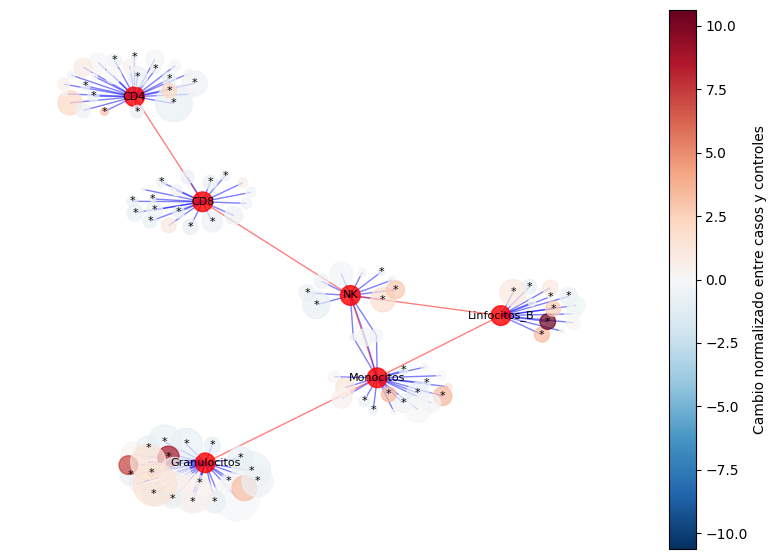

In [84]:
G_resumen = nx.Graph()

# 1. Agregar todos los nodos padre
for padre in jerarquia.keys():
    G_resumen.add_node(padre, tipo='padre', color='red', size=200)

# 2. Asociar clusters a cada padre
dict_padre_clusters = {}
dict_padre_gating = {}
for padre, gating_list in jerarquia.items():
    gating_en_G = [g for g in gating_list if g in G.nodes()]
    dict_padre_gating[padre] = gating_en_G
    clusters_encontrados = set()
    for gating in gating_en_G:
        for vecino in G.neighbors(gating):
            if G.nodes[vecino].get('tipo') == 'cluster':
                clusters_encontrados.add(vecino)
    dict_padre_clusters[padre] = clusters_encontrados

# 3. Añadir nodos cluster y aristas azules padre→cluster
for padre, conjunto_clusters in dict_padre_clusters.items():
    for cluster in conjunto_clusters:
        if cluster not in G_resumen:
            color_cluster = color_map.get(cluster, '#cccccc')
            size_cluster = tamanos_clusters.get(cluster, 100) / 100
            G_resumen.add_node(
                cluster,
                tipo='cluster',
                color=color_cluster,
                size=size_cluster
            )
            G_resumen.nodes[cluster]['label'] = label_map.get(cluster, cluster)
        if not G_resumen.has_edge(padre, cluster):
            G_resumen.add_edge(padre, cluster, color='blue', weight=1)

# 4. Aristas rojas padre↔padre si comparten gating conectado en G
lista_padres = list(jerarquia.keys())
for i in range(len(lista_padres)):
    p1 = lista_padres[i]
    gating_p1 = dict_padre_gating[p1]
    for j in range(i + 1, len(lista_padres)):
        p2 = lista_padres[j]
        gating_p2 = dict_padre_gating[p2]
        if any(G.has_edge(g1, g2) for g1 in gating_p1 for g2 in gating_p2):
            if not G_resumen.has_edge(p1, p2):
                G_resumen.add_edge(p1, p2, color='red', weight=1)

# 5. Etiquetas
for nodo in G_resumen.nodes():
    if G_resumen.nodes[nodo]['tipo'] == 'padre':
        G_resumen.nodes[nodo]['label'] = nodo
    elif 'label' not in G_resumen.nodes[nodo]:
        G_resumen.nodes[nodo]['label'] = nodo

# 6. Dibujar y mostrar
pos_resumen = nx.spring_layout(G_resumen, seed=1, k=0.07)
fig, ax = plt.subplots(figsize=(10, 7))

nodos_padre = [n for n in G_resumen if G_resumen.nodes[n]['tipo'] == 'padre']
nodos_cluster = [n for n in G_resumen if G_resumen.nodes[n]['tipo'] == 'cluster']

nx.draw_networkx_nodes(
    G_resumen, pos_resumen,
    nodelist=nodos_padre,
    node_color=[G_resumen.nodes[n].get('color', 'darkred') for n in nodos_padre],
    node_size=[G_resumen.nodes[n].get('size', 200) for n in nodos_padre],
    alpha=0.8
)
nx.draw_networkx_nodes(
    G_resumen, pos_resumen,
    nodelist=nodos_cluster,
    node_color=[G_resumen.nodes[n].get('color', '#cccccc') for n in nodos_cluster],
    node_size=[G_resumen.nodes[n].get('size', 100) for n in nodos_cluster],
    alpha=0.7
)

nx.draw_networkx_edges(
    G_resumen, pos_resumen,
    edge_color=[G_resumen[u][v].get('color', 'blue') for u, v in G_resumen.edges()],
    alpha=0.5
)

labels = {n: G_resumen.nodes[n].get('label', n) for n in G_resumen.nodes()}
nx.draw_networkx_labels(G_resumen, pos_resumen, labels, font_size=8, font_color='black')

plt.axis('off')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Cambio normalizado entre casos y controles')

plt.show()

In [87]:
results_df

,Cluster,Control_Mean,Case_Mean,Change,pvalue,p_adj
0,C_1,6114.6,1568.200000,-0.743532,0.002076,0.005634
1,C_10,661.0,4580.933333,5.930308,0.028447,0.051476
2,C_11,200.1,1284.133333,5.417458,0.127153,0.178956
3,C_12,1578.7,2753.533333,0.744178,0.677333,0.735390
4,C_15,527.4,514.466667,-0.024523,0.802885,0.846062
5,C_16,3216.4,4786.000000,0.487999,0.846062,0.846062
6,C_18,453.9,1196.600000,1.636263,0.032712,0.056503
7,C_19,1080.6,877.200000,-0.188229,0.141574,0.192136
8,C_2,24567.0,6768.000000,-0.724508,0.000116,0.001375
9,C_20,367.3,3351.533333,8.124784,0.028447,0.051476
